In [1]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm
import elm
from cnn import CNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy
import scipy.io
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
DEVICE = '/device:GPU:1'
EPOCHS = 50
BATCH_SIZE = 256
w = 1       
SAVE_PATH = 'backup/'

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## load feature2 images

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
train_data = unpickle(r'./data/SEED1/feature2_imgs/train_images')

In [4]:
x_train = train_data['data']
y_train = train_data['label']

In [17]:
X = tf.placeholder(tf.float32, [None, 9, 9, 5])
Y = tf.placeholder(tf.float32, [None, 3])
LR = tf.placeholder(tf.float32)

In [18]:
net = CNN(X, Y, DEVICE)

In [19]:
optimizer = tf.train.AdamOptimizer(LR).minimize(net.loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(net.logits,1)), dtype=tf.float32))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False,allow_soft_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

In [20]:
saver.restore(sess, SAVE_PATH+'model.ckpt')

INFO:tensorflow:Restoring parameters from backup/model.ckpt


In [ ]:
allloss = []
with tf.device(DEVICE):
    epoch = 0
    test_acc = []
    while epoch < EPOCHS:
        total_steps = int(x_train.shape[0]/BATCH_SIZE)
        for step in tqdm(range(total_steps), desc=('Epoch '+str(epoch))):  
            if step*BATCH_SIZE + BATCH_SIZE < x_train.shape[0]:
                BATCH_X = x_train[step*BATCH_SIZE: step*BATCH_SIZE+BATCH_SIZE]
                BATCH_Y = y_train[step*BATCH_SIZE: step*BATCH_SIZE+BATCH_SIZE]
            else:
                BATCH_X = x_train[step*BATCH_SIZE:]
                BATCH_Y = y_train[step*BATCH_SIZE:]
    
            [loss_value, _] = sess.run([net.loss, optimizer], feed_dict={X: BATCH_X, LR: 0.001})
        allloss.append(loss_value)
        print("epoch %d: loss %f" % (epoch, loss_value))  
        saver.save(sess, SAVE_PATH+'model.ckpt')
        epoch += 1

In [ ]:
plt.plot(allloss)
plt.show()

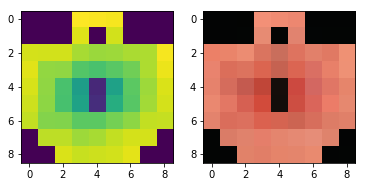

In [21]:
img = np.array([x_train[6223]])
img_decoder = sess.run(net.logits, feed_dict={X:img})

img_decoder = img_decoder.reshape(9,9,5)[:,:,:3]

plt.subplot(1,2,1)
plt.imshow(img[0][:,:,1])

plt.subplot(1,2,2)
plt.imshow(img_decoder)

In [22]:
def load_label(fromIndex, toIndex):
    label = scipy.io.loadmat("./data/SEED1/processed_data/label.mat")["label"]
    return label[0][fromIndex:toIndex]+1

def load(time_index, person_index, movie_st, movie_end):
    labellist = load_label(movie_st, movie_end) 
    data = []
    labels = []
    sample_number = []
    for loop_person in range(person_index-1, person_index):
        person_name = 'person%d' % (loop_person + 1)
        for loop_time in range(time_index-1, time_index):
            name_time = '_time%d' % (loop_time + 1)
            filename = person_name + name_time + '.mat'
            filedata = scipy.io.loadmat("./data/SEED1/processed_data/data/" + filename)
                
            for index in range(movie_st, movie_end):
                label = labellist[index - movie_st]
                feats = filedata['de_LDS' + str(index+1)]
                feats = feats.transpose()

                for j in range(feats.shape[1]):
                    data1 = []
                    for i in range(feats.shape[0]):
                        data1 = np.append(data1, feats[i][j])
                    data.append(data1)
                    labels.append(label)
                sample_number.append(feats.shape[1])
    sample_number = np.array(sample_number).T
    dataset = np.array(data)
    labels = np.array(labels).reshape(len(labels), 1)
    d = np.concatenate((labels, dataset), axis = 1)
    return d, sample_number

def transfor(dataset):
    im = np.zeros([9, 9])
    im[0, 3] = dataset[0]
    im[0, 4] = dataset[1]
    im[0, 5] = dataset[2]
    
    im[1, 3] = dataset[3]
    im[1, 5] = dataset[4]

    im[2, 0] = dataset[5]
    im[2, 1] = dataset[6]
    im[2, 2] = dataset[7]
    im[2, 3] = dataset[8]
    im[2, 4] = dataset[9]
    im[2, 5] = dataset[10]
    im[2, 6] = dataset[11]
    im[2, 7] = dataset[12]
    im[2, 8] = dataset[13]

    im[3, 0] = dataset[14]
    im[3, 1] = dataset[15]
    im[3, 2] = dataset[16]
    im[3, 3] = dataset[17]
    im[3, 4] = dataset[18]
    im[3, 5] = dataset[19]
    im[3, 6] = dataset[20]
    im[3, 7] = dataset[21]
    im[3, 8] = dataset[22]

    im[4, 0] = dataset[23]
    im[4, 1] = dataset[24]
    im[4, 2] = dataset[25]
    im[4, 3] = dataset[26]
    im[4, 4] = dataset[27]
    im[4, 5] = dataset[28]
    im[4, 6] = dataset[29]
    im[4, 7] = dataset[30]
    im[4, 8] = dataset[31]

    im[5, 0] = dataset[32]
    im[5, 1] = dataset[33]
    im[5, 2] = dataset[34]
    im[5, 3] = dataset[35]
    im[5, 4] = dataset[36]
    im[5, 5] = dataset[37]
    im[5, 6] = dataset[38]
    im[5, 7] = dataset[39]
    im[5, 8] = dataset[40]

    im[6, 0] = dataset[41]
    im[6, 1] = dataset[42]
    im[6, 2] = dataset[43]
    im[6, 3] = dataset[44]
    im[6, 4] = dataset[45]
    im[6, 5] = dataset[46]
    im[6, 6] = dataset[47]
    im[6, 7] = dataset[48]
    im[6, 8] = dataset[49]

    im[7, 1] = dataset[50]
    im[7, 2] = dataset[51]
    im[7, 3] = dataset[52]
    im[7, 4] = dataset[53]
    im[7, 5] = dataset[54]
    im[7, 6] = dataset[55]
    im[7, 7] = dataset[56]

    im[8, 2] = dataset[57]
    im[8, 3] = dataset[58]
    im[8, 4] = dataset[59]
    im[8, 5] = dataset[60]
    im[8, 6] = dataset[61]

    im = im.reshape(im.shape[0], im.shape[1], 1)
    return im

def convert(d):
    images = []
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    d = min_max_scaler.fit_transform(d.T).transpose()
    for i in range(d.shape[0]):
        image = convert2img(d[i])
        images.append(image)
    return np.array(images)

def convert2img(datarow):
    f0 = transfor(datarow[:62])
    f1 = transfor(datarow[62:124])
    f2 = transfor(datarow[124:186])
    f3 = transfor(datarow[186:248])
    f4 = transfor(datarow[248:310])
    
    image = np.concatenate((f0, f1, f2, f3, f4), axis=2)
    return image

def picklefile(file, data):
    with open(file,'wb') as f:
        pickle.dump(data,f)

In [24]:
for _time in range(1, 4):    
    for loop in range(1, 15):
        Training, _ = load(_time, loop, 0, 9)
        Testing, _ = load(_time, loop, 9, 15)
        train_imgs = convert(Training[:,1:])
        test_imgs = convert(Testing[:,1:])
        train_feature = sess.run(net.encoder, feed_dict={X:train_imgs})
        test_feature = sess.run(net.encoder, feed_dict={X:test_imgs})
            
        traininfo = {'':'', 'data':train_feature}
        picklefile(r'./data/SEED1/feature2/train_' + str(_time) + '_' + str(loop), traininfo)
        traininfo = {'':'', 'data':test_feature}
        picklefile(r'./data/SEED1/feature2/test_' + str(_time) + '_' + str(loop), traininfo)